In [1]:
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import Adam
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Load and Visualize Data

In [2]:
(X_train, _), (_, _) = mnist.load_data()
X_train.shape

(60000, 28, 28)

In [3]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_train = (X_train - 127.5) / 127.5
X_train.shape

(60000, 28, 28, 1)

(-0.5, 27.5, 27.5, -0.5)

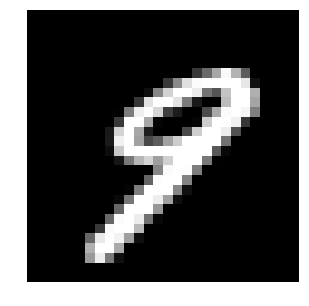

In [4]:
img = X_train[np.random.randint(0,X_train.shape[0]),:,:,0]
plt.figure(figsize=(5,5))
plt.imshow(img, cmap='gray')
plt.axis('off')

# Build Generator

In [5]:
generator = Sequential([
        Dense(128*7*7, input_dim=100),
        LeakyReLU(0.2),
        BatchNormalization(),
        Reshape((7,7,128)),
        UpSampling2D(),
        Conv2D(64, 5, padding='same'),
        LeakyReLU(0.2),
        BatchNormalization(),
        UpSampling2D(),
        Conv2D(1, 5, padding='same', activation='tanh')
    ])

In [6]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6272)              25088     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
__________

# Build Discriminator

In [7]:
discriminator = Sequential([
        Conv2D(64, 5, strides=(2,2), input_shape=(28,28,1), padding='same'),
        LeakyReLU(0.2),
        Dropout(0.3),
        Conv2D(128, 5, strides=(2,2), padding='same'),
        LeakyReLU(0.2),
        Dropout(0.3),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])

In [8]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
__________

In [9]:
generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

In [10]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

# Build GAN

In [11]:
discriminator.trainable = False
ganInput = Input(shape=(100,))
# getting the output of the generator
# and then feeding it to the discriminator
# new model = D(G(input))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

In [12]:
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


# Train the Model

In [13]:
def train(epoch=10, batch_size=128):
    batch_count = X_train.shape[0] // batch_size
    
    for i in range(epoch):
        for j in tqdm(range(batch_count)):
            # Input for the generator
            noise_input = np.random.rand(batch_size, 100)
            
            # getting random images from X_train of size=batch_size 
            # these are the real images that will be fed to the discriminator
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
            
            # these are the predicted images from the generator
            predictions = generator.predict(noise_input, batch_size=batch_size)
            
            # the discriminator takes in the real images and the generated images
            X = np.concatenate([predictions, image_batch])
            
            # labels for the discriminator
            y_discriminator = [0]*batch_size + [1]*batch_size
            
            # Let's train the discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_discriminator)
            
            # Let's train the generator
            noise_input = np.random.rand(batch_size, 100)
            y_generator = [1]*batch_size
            discriminator.trainable = False
            gan.train_on_batch(noise_input, y_generator)

In [14]:
train(50,128)

100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:19<00:00, 24.36it/s]


In [15]:
generator.save_weights('gen_base.h5')
discriminator.save_weights('discrim_base.h5')

In [16]:
noise = np.random.rand(1,100)
generated_image = generator.predict(noise, verbose=1)[0,:,:,0]
generated_image.shape

1/1 [==============================] - 0s 32ms/step


(28, 28)

(-0.5, 9.5, 9.5, -0.5)

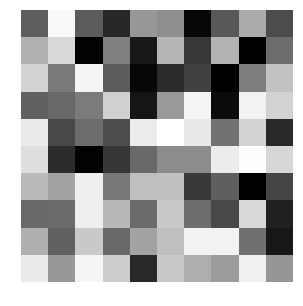

In [17]:
plt.figure(figsize=(5,5))
plt.imshow(noise.reshape(10,10), cmap='gray')
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

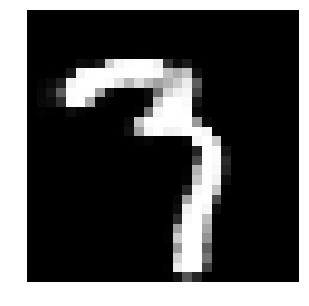

In [18]:
attempt = 'base.jpg'
plt.figure(figsize=(5,5))
plt.imshow(generated_image, cmap='gray')
plt.savefig(attempt)
plt.axis('off')

1/1 [==============================] - 0s 2ms/step


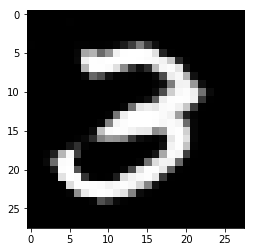

In [19]:
for i in range(1,50):
    noise = np.random.rand(1,100)
    generated_image = generator.predict(noise, verbose=1)[0,:,:,0]
    plt.imshow(generated_image, cmap="gray")
    plt.savefig('{}.jpg'.format(i))